In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import ttest_ind, ks_2samp

# Display all columns
pd.set_option('display.max_columns', None)

In [21]:
# Load the stage 4 property data
df = pd.read_csv(r'Output Files\stage_4_property_data.csv') 
df.head(3)

,Possession Status,Availability Starts From,Floor No,Commercial,Developer,Price (Crores),Landmark,Covered Area,Society,sqft Price (INR),Carpet Area,Area,Unit of Carpet Area,Furnished Type,Bathrooms,Facing,Transaction Type,Type of Property,City,Bedrooms,Posted By,Total Floors,isPrimeLocationProperty,Unit of Covered Area,Property Lifespan,Balconies,Power Back Up,Lift,Rain Water Harvesting,Club House,Swimming Pool,Gymnasium,Park,Parking,Security,Water Storage,Private Terrace/Garden,Vaastu Compliant,Service/Goods Lift,Air Conditioned,Visitor Parking,Intercom Facility,Maintenance Staff,Waste Disposal,Laundry Service,Internet/Wi-Fi Connectivity,DTH Television Facility,RO Water System,Banquet Hall,Bar/Lounge,Cafeteria/Food Court,Conference Room,Piped Gas,Jogging and Strolling Track,Outdoor Tennis Courts,Mansion,Downtown,Skyline View,Wrap Around Balcony,Island Kitchen Layout,Full Glass Wall,House help accommodation,Concierge Services,Garden View,Marble flooring,Well Furnished,Modular Kitchen,Helipad,Private pool,Private Jaccuzi,Mini Cinema Theatre,Golf Course,Infinity Swimming Pool,Pool with temperature control,Sea facing,Skydeck,Earth quake resistant,Theme based Architectures,Health club with Steam / Jaccuzi,Large Clubhouse,Large Open space,Fingerprint Access,Grand Entrance lobby,Private Garage,Fireplace,Wine Cellar,Sky Villa,Water Front,Hilltop,Smart Home,Barbeque space,Kids play area,Library,Puja Room,Study,Servant Room,Store,Aerobics Room,Canopy Walk,Coffee Lounge & Restaurants,Dance Studio,Event Space & Amphitheatre,Flower Gardens,Guest Accommodation,Indoor Squash & Badminton Courts,Kids Play Area,Kids Play Pool With Water Slides,Library And Business Centre,Meditation Area,Multipurpose Courts,Recreational Pool,Rentable CommuniPfty Space,Retail Boulevard (Retail Shops),Cycling & Jogging Track,Fire Fighting Equipment,Aesthetically designed landscape garden,latitude,longitude,geocoded_address,Area_Broader,Price_bin
0,Ready to Move,Immediately,20.0,Y,Tata Housing Development Company Ltd.,0.63,Rajoli naka,763.571943,Tata Amantra,8250.696031,579.0,Kalyan West,Sq-ft,Unfurnished,2.0,East,New Property,Apartment,Thane,2,Agent,34.0,Y,Sq-ft,New construction,2.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.240353,73.125279,"Kalyan West, Kalyan-Dombivli, Kalyan Taluka, T...",Kalyan West,Low
1,Ready to Move,Immediately,18.0,N,Sai Satyam Developers,0.54,This property has reputed scholl ints vicinity.,850.000000,Sai Satyam Homes,6352.000000,585.0,Kalyan West,Sq-ft,Unfurnished,2.0,East,New Property,Apartment,Thane,2,Agent,18.0,Y,Sq-ft,New construction,2.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.240353,73.125279,"Kalyan West, Kalyan-Dombivli, Kalyan Taluka, T...",Kalyan West,Low
2,Under Construction,Dec 25,5.0,N,Birla Estates,0.90,Shahad is one of the attractive locations to o...,1050.000000,Birla Vanya,8571.000000,815.0,Kalyan West,Sq-ft,Unfurnished,2.0,East,New Property,Apartment,Thane,2,Agent,27.0,Y,Sq-ft,Less than 5 years,3.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.240353,73.125279,"Kalyan West, Kalyan-Dombivli, Kalyan Taluka, T...",Kalyan West,Medium


In [22]:
# Check shape
df.shape

(6290, 121)

# <b>Feature engineering</b>

#### Utilities

In [23]:
# Function to plot Distribution plot and Box plot for a dataframe column
def plot_distribution_and_boxplot(df: pd.DataFrame, column: str):
    """
    Plot histogram with KDE and boxplot for a given column in a DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame
        column (str): Column name to plot
    """
    sns.set_style('whitegrid')
    palette = sns.color_palette('pastel')

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Distribution plot on the left
    sns.histplot(df[column].dropna(), kde=True, color=palette[0], ax=axes[0], edgecolor='black', linewidth=0.7)

    axes[0].set_title(f'Distribution of {column}', fontsize=16, fontweight='bold')
    axes[0].set_xlabel(column, fontsize=14)
    axes[0].set_ylabel('Density', fontsize=14)

    # Box plot on the right
    sns.boxplot(x=df[column], color=palette[1], ax=axes[1], fliersize=5, linewidth=1.2)
    axes[1].set_title(f'Boxplot of {column}', fontsize=16, fontweight='bold')
    axes[1].set_xlabel(column, fontsize=14)
    axes[1].set_yticks([])  # Hide y-axis ticks for boxplot

    plt.tight_layout()
    plt.show()

-----------------

Rename features:

In [24]:
# Rename 'Area' and 'Area_Broader'
df.rename(columns={'Area': 'Locality', 'Area_Broader': 'Area'}, inplace=True)

# Rename Servant Room and Store
df.rename(columns={'Servant Room': 'House Help Room', 'Store': 'Store Room'}, inplace=True)

Remove Property listings with very less frequent occuring area in dataset:

In [25]:
# Filter out less occuring areas
less_occuring_areas = df['Area'].value_counts()[df['Area'].value_counts() < 3].index

# Remove property listings with less occuring areas
df = df[~(df['Area'].isin(less_occuring_areas))]

In [26]:
# Check updated shape
df.shape

(6281, 121)

In [27]:
# Info
pd.set_option('display.max_info_columns', 200)
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 6281 entries, 0 to 6289
Data columns (total 121 columns):
 #    Column                                   Non-Null Count  Dtype  
---   ------                                   --------------  -----  
 0    Possession Status                        6281 non-null   object 
 1    Availability Starts From                 6281 non-null   object 
 2    Floor No                                 6281 non-null   float64
 3    Commercial                               6281 non-null   object 
 4    Developer                                6281 non-null   object 
 5    Price (Crores)                           6281 non-null   float64
 6    Landmark                                 6281 non-null   object 
 7    Covered Area                             6281 non-null   float64
 8    Society                                  6281 non-null   object 
 9    sqft Price (INR)                         6281 non-null   float64
 10   Carpet Area                            

----------

Construct a new Feature 'Floor Level' depending upon Floor No:

-----------Statistics of Floor No------------
count    6281.000000
mean       10.790957
std         9.411273
min        -2.000000
25%         4.000000
50%         8.000000
75%        15.000000
max        93.000000
Name: Floor No, dtype: float64



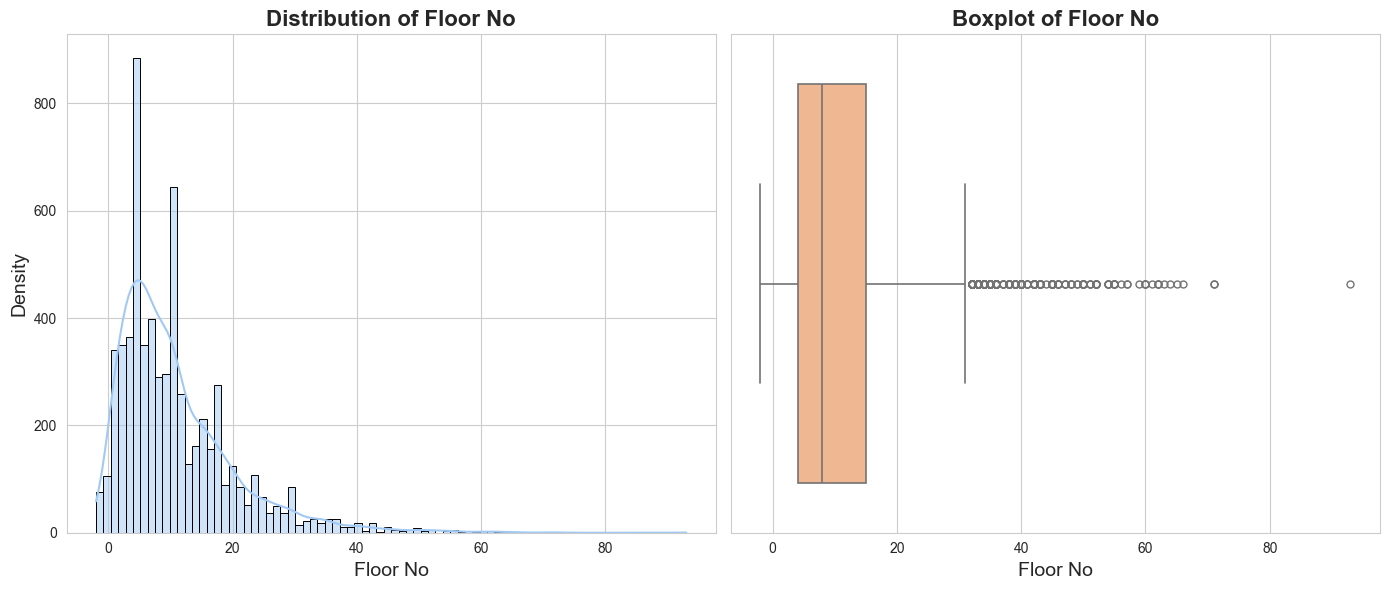

In [28]:
# Statistics of Floor No
print('-----------Statistics of Floor No------------')
print(df['Floor No'].describe())
print()

# Distribution and Box plot of Floor No
plot_distribution_and_boxplot(df, 'Floor No')

In [29]:
# Permanently drop properties having Floor No greater than 75

# Get IDs
idx = df[df['Floor No'] > 75].index

# Drop
df.drop(index=idx, inplace=True)

In [30]:
# Updated shape
df.shape

(6280, 121)

In [31]:
# Initialize 'Floor Level' feature in df with null values
df['Floor Level'] = np.nan

In [32]:
def categorize_floor_number(row: pd.Series) -> str:
    ''' 
    Function to categorize Floor No of property

    Args:
        row: Property in Series form
    '''

    floor_number = row['Floor No']

    if floor_number < 5:
        floor_level = 'Low rise (< 5)'
    elif floor_number >= 5 and floor_number <= 10:
        floor_level = 'Mid rise (5 to 10)'
    else:
        floor_level = 'High rise (> 10)'

    return floor_level


In [33]:
# Categorize properties Floor No
df['Floor Level'] = df.apply(categorize_floor_number, axis=1)

-----------------

Combine multiple Amenities fetures into a single feature 'Luxury Score':

In [34]:
# Assign weights to Amenities based on perceived luxury contribution
amenities_weights = {
  'Private Terrace/Garden': 8,
  'Air Conditioned': 7,
  'Skyline View': 8,
  'Wrap Around Balcony': 7,
  'House help accommodation': 7,
  'Garden View': 7,
  'Marble flooring': 7,
  'Modular Kitchen': 6,
  'Private pool': 10,
  'Private Jaccuzi': 10,
  'Pool with temperature control': 9,
  'Sea facing': 10,
  'Grand Entrance lobby': 8,
  'Private Garage': 8,
  'Smart Home': 8,
  'Barbeque space': 7,
  'Puja Room': 5,
  'Study': 5,
  'Aerobics Room': 6,
  'Meditation Area': 6,
  'Power Back Up': 4,
  'Lift': 2,
  'Rain Water Harvesting': 5,
  'Club House': 6,
  'Swimming Pool': 6,
  'Gymnasium': 6,
  'Park': 5,
  'Parking': 4,
  'Security': 6,
  'Water Storage': 2,
  'Service/Goods Lift': 3,
  'Visitor Parking': 4,
  'Intercom Facility': 3,
  'Maintenance Staff': 3,
  'Waste Disposal': 3,
  'Laundry Service': 4,
  'Internet/Wi-Fi Connectivity': 3,
  'DTH Television Facility': 2,
  'RO Water System': 3,
  'Banquet Hall': 7,
  'Bar/Lounge': 8,
  'Cafeteria/Food Court': 6,
  'Conference Room': 6,
  'Piped Gas': 3,
  'Jogging and Strolling Track': 6,
  'Outdoor Tennis Courts': 7,
  'Downtown': 7,
  'Concierge Services': 9,
  'Helipad': 0,  # Data is not reliable
  'Mini Cinema Theatre': 9,
  'Golf Course': 10,
  'Earth quake resistant': 5,
  'Theme based Architectures': 6,
  'Health club with Steam / Jaccuzi': 8,
  'Large Clubhouse': 8,
  'Fingerprint Access': 7,
  'Fireplace': 5,
  'Water Front': 9,
  'Hilltop': 8,
  'Kids play area': 0,
  'Library': 6,
  'Canopy Walk': 7,
  'Coffee Lounge & Restaurants': 7,
  'Dance Studio': 6,
  'Event Space & Amphitheatre': 8,
  'Flower Gardens': 6,
  'Guest Accommodation': 7,
  'Indoor Squash & Badminton Courts': 8,
  'Library And Business Centre': 7,
  'Multipurpose Courts': 6,
  'Rentable CommuniPfty Space': 5,
  'Retail Boulevard (Retail Shops)': 7,
  'Cycling & Jogging Track': 7,
  'Fire Fighting Equipment': 2,
  'Aesthetically designed landscape garden': 6,
  'Mansion': 0,  # Data is not reliable 
  'Island Kitchen Layout': 7,
  'Full Glass Wall': 0,
  'Well Furnished': 0,  # Already covered in Furnished feature
  'Infinity Swimming Pool': 9,
  'Skydeck': 0,    # Data is not reliable
  'Large Open space': 8,
  'Wine Cellar': 0,    # Data is not reliable
  'Sky Villa': 0,    # Data is not reliable
  'Kids Play Area': 5,
  'Kids Play Pool With Water Slides': 7,
  'Recreational Pool': 0
}

In [35]:
# Initialize 'Luxury Score' feature in property dataframe with null values
df['Luxury Score'] = np.nan

# Initialize 'Amenities String' feature in property dataframe with null values
df['Amenities String'] = np.nan

In [36]:
def luxury_score(row: pd.Series) -> float:
    '''
    Assigns Luxury score to a property based on amenities

    Args:
        row: Property in Series form
    '''
    score = 0.0
    amenities_list = []
    for amenity in list(amenities_weights.keys()):
        if row[amenity] == 1:
            # Get amenity weight
            amenity_weight = amenities_weights[amenity]
            score += amenity_weight

            # Add amenity to amenities list
            if amenity_weight != 0:
                amenities_list.append(amenity)
    
    return score, ', '.join(amenities_list)

In [37]:
# Assign Luxury score and Amenities String to properties
df[['Luxury Score', 'Amenities String']] = pd.DataFrame(df.apply(luxury_score, axis=1).tolist(), index=df.index)

In [38]:
# Drop individual Amenity features form the dataframe permanently
individual_amenities = amenities_weights.keys()
to_remove = ['Air Conditioned', 'Marble flooring', 'Modular Kitchen', 'Smart Home', 'Puja Room', 'Study']
individual_amenities = [amenity for amenity in individual_amenities if amenity not in to_remove]

df.drop(columns=individual_amenities, inplace=True)

In [39]:
# Check Shape
df.shape

(6280, 43)

-----------Statistics of Luxury Score------------
count    6280.000000
mean      297.712261
std       228.430475
min         0.000000
25%        22.000000
50%       488.000000
75%       488.000000
max       488.000000
Name: Luxury Score, dtype: float64



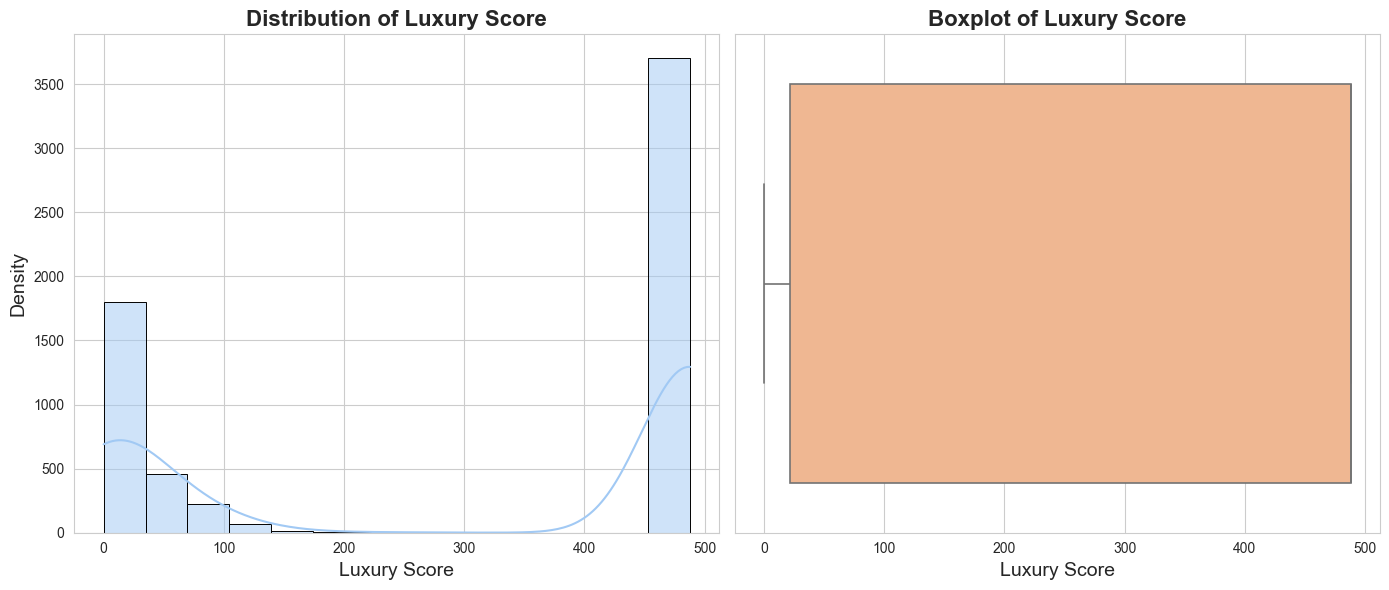

In [42]:
# Study 'Luxury Score' feature

# Statistics
print('-----------Statistics of Luxury Score------------')
print(df['Luxury Score'].describe())
print()
# Polt distribution and box plot
plot_distribution_and_boxplot(df, 'Luxury Score')

-------------

Construct feature 'Luxury Category' to categorize 'Luxury Scores':

In [43]:
# Initialize Luxury category feature with null values
df['Luxury Category'] = np.nan

In [44]:
def categorize_luxury_scores(row: pd.Series) -> object:
    '''
    Categorizes Properties luxury scores into three categories based on rules

    Args:
        row: Property in series form
    '''

    score = row['Luxury Score']

    if score <= 30:
        category = 'Basic'
    elif score > 30 and score < 250:
        category = 'Medium'
    else:
        category = 'High'

    return category

In [45]:
# Assign Luxury Category to properties
df['Luxury Category'] = df.apply(categorize_luxury_scores, axis=1)

In [46]:
# Drop Luxury Score feature permanently
df.drop(columns=['Luxury Score'], inplace=True)

In [47]:
# Check updated shape
df.shape

(6280, 43)

In [48]:
# Sample
df.sample(4)

,Possession Status,Availability Starts From,Floor No,Commercial,Developer,Price (Crores),Landmark,Covered Area,Society,sqft Price (INR),Carpet Area,Locality,Unit of Carpet Area,Furnished Type,Bathrooms,Facing,Transaction Type,Type of Property,City,Bedrooms,Posted By,Total Floors,isPrimeLocationProperty,Unit of Covered Area,Property Lifespan,Balconies,Vaastu Compliant,Air Conditioned,Marble flooring,Modular Kitchen,Smart Home,Puja Room,Study,House Help Room,Store Room,latitude,longitude,geocoded_address,Area,Price_bin,Floor Level,Amenities String,Luxury Category
2677,Under Construction,Dec 25,16.0,N,Runwal Developers,0.63,Ee highway & ghodbunder road 10 min::::thane s...,610.000000,Runwal Codename Enchanted,10327.000000,390.000000,Kolshet,Sq-ft,Semi-Furnished,2.0,North-East,New Property,Apartment,Thane,1,Agent,52.0,Y,Sq-ft,New construction,1.0,1,1,1,1,1,1,1,1,1,19.238902,72.993269,"Kolshet, Thane, Thane Taluka, Thane, Maharasht...",Thane West,Low,High rise (> 10),"Private Terrace/Garden, Air Conditioned, Skyli...",High
5197,Ready to Move,Immediately,17.0,N,Shapoorji Pallonji Group,1.80,Not Available,873.999829,Sarova Epsilon,20594.969711,631.000000,Kandivali East,Sq-ft,Unfurnished,2.0,West,Resale,Apartment,Mumbai,2,Agent,37.0,Y,Sq-ft,New construction,1.0,0,0,0,0,0,0,0,0,0,19.205196,72.862617,"Kandivali East, R/S Ward, Zone 4, Mumbai Subur...",Kandivali East,High,High rise (> 10),,Basic
5470,Ready to Move,Immediately,4.0,N,Mega Realtors,0.20,Not Available,355.000000,Shiv Kutir,5634.000000,287.575407,Andheri West,Sq-ft,Unfurnished,1.0,North-East,Resale,Apartment,Mumbai,1,Owner,5.0,N,Sq-ft,5 to 10 years,1.0,0,0,0,0,0,0,0,0,0,19.117249,72.833968,"Andheri West, K/W Ward, Zone 3, Mumbai Suburba...",Andheri West,Low,Low rise (< 5),,Basic
1058,Ready to Move,Immediately,10.0,N,Raj Realty Group,0.75,Vaishali nagar dahisar east off western exp hi...,693.000000,Rudraksh,10822.000000,443.000000,Dahisar East,Sq-ft,Semi-Furnished,2.0,East,New Property,Apartment,Mumbai,1,Agent,22.0,Y,Sq-ft,New construction,3.0,1,1,1,1,1,1,1,1,1,19.054999,72.869203,"Mumbai Suburban, Maharashtra, India",Dahisar East,Low,Mid rise (5 to 10),"Private Terrace/Garden, Air Conditioned, Skyli...",High


-----------------

Assign Balconies value to '3+' if balconies is greater then 3:

In [49]:
# Get IDs of properties where Balconies is greater than 3
idx = df[df['Balconies'] > 3].index

# Replace Balconies value
df.loc[idx, 'Balconies'] = '3+'

In [50]:
# Convert the column to string (object) dtype
df['Balconies'] = df['Balconies'].astype(str)

In [51]:
# Sample
df.sample(3)

,Possession Status,Availability Starts From,Floor No,Commercial,Developer,Price (Crores),Landmark,Covered Area,Society,sqft Price (INR),Carpet Area,Locality,Unit of Carpet Area,Furnished Type,Bathrooms,Facing,Transaction Type,Type of Property,City,Bedrooms,Posted By,Total Floors,isPrimeLocationProperty,Unit of Covered Area,Property Lifespan,Balconies,Vaastu Compliant,Air Conditioned,Marble flooring,Modular Kitchen,Smart Home,Puja Room,Study,House Help Room,Store Room,latitude,longitude,geocoded_address,Area,Price_bin,Floor Level,Amenities String,Luxury Category
2684,Under Construction,Dec 26,11.0,Y,Rustomjee,1.25,"The project is close to metro station ,has a ...",1000.0,Rustomjee Uptown Urbania,12500.0,650.0,Thane West,Sq-ft,Unfurnished,2.0,East,New Property,Apartment,Thane,2,Agent,55.0,Y,Sq-ft,New construction,2.0,1,1,1,1,1,1,1,1,1,19.186527,72.974922,"Thane Station West 2 Wheeler Parking, Station ...",Thane West,Medium,High rise (> 10),"Private Terrace/Garden, Air Conditioned, Skyli...",High
3858,Ready to Move,Immediately,11.0,N,Starwing Developers Pvt. Ltd.,2.90,Bmc office,1125.0,Apurva Residence,25777.0,750.0,Azad Nagar,Sq-ft,Furnished,2.0,East,Resale,Apartment,Mumbai,2,Agent,16.0,Y,Sq-ft,10 to 15 years,1.0,1,1,1,1,1,1,1,1,1,19.092060,72.899401,"Azad Nagar, N Ward, Zone 6, Mumbai Suburban, M...",Andheri West,Very High,High rise (> 10),"Private Terrace/Garden, Air Conditioned, Skyli...",High
4845,Ready to Move,Immediately,18.0,N,Acme Group,1.50,Charkop,1257.0,Acme Avenue,11933.0,780.0,Kandivali West,Sq-ft,Unfurnished,2.0,West,Resale,Apartment,Mumbai,2,Agent,33.0,Y,Sq-ft,New construction,2.0,1,1,1,1,1,0,1,1,1,19.205532,72.839927,"Kandivali West, R/S Ward, Zone 4, Mumbai Subur...",Kandivali West,Medium,High rise (> 10),"Private Terrace/Garden, Air Conditioned, Skyli...",High


In [52]:
# Export the dataframe into a csv file
df.to_csv('Output Files//stage_5_property_data.csv', index=False)